In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
from google.cloud import bigquery

In [0]:
%load_ext google.colab.data_table

In [0]:
project_id = 'willkommenvinzenz'

In [6]:
%env GCLOUD_PROJECT=willkommenvinzenz

env: GCLOUD_PROJECT=willkommenvinzenz


In [0]:
client = bigquery.Client(project=project_id)

In [0]:
"""
Helper class to simplify common read-only BigQuery tasks.
"""


import pandas as pd
import time

from google.cloud import bigquery


class BigQueryHelper(object):
    """
    Helper class to simplify common BigQuery tasks like executing queries,
    showing table schemas, etc without worrying about table or dataset pointers.

    See the BigQuery docs for details of the steps this class lets you skip:
    https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html
    """

    def __init__(self, active_project, dataset_name, max_wait_seconds=180):
        self.project_name = active_project
        self.dataset_name = dataset_name
        self.max_wait_seconds = max_wait_seconds
        self.client = bigquery.Client()
        self.__dataset_ref = self.client.dataset(self.dataset_name, project=self.project_name)
        self.dataset = None
        self.tables = dict()  # {table name (str): table object}
        self.__table_refs = dict()  # {table name (str): table reference}
        self.total_gb_used_net_cache = 0
        self.BYTES_PER_GB = 2**30

    def __fetch_dataset(self):
        """
        Lazy loading of dataset. For example,
        if the user only calls `self.query_to_pandas` then the
        dataset never has to be fetched.
        """
        if self.dataset is None:
            self.dataset = self.client.get_dataset(self.__dataset_ref)

    def __fetch_table(self, table_name):
        """
        Lazy loading of table
        """
        self.__fetch_dataset()
        if table_name not in self.__table_refs:
            self.__table_refs[table_name] = self.dataset.table(table_name)
        if table_name not in self.tables:
            self.tables[table_name] = self.client.get_table(self.__table_refs[table_name])

    def __handle_record_field(self, row, schema_details, top_level_name=''):
        """
        Unpack a single row, including any nested fields.
        """
        name = row['name']
        if top_level_name != '':
            name = top_level_name + '.' + name
        schema_details.append([{
            'name': name,
            'type': row['type'],
            'mode': row['mode'],
            'fields': pd.np.nan,
            'description': row['description']
                               }])
        # float check is to dodge row['fields'] == np.nan
        if type(row.get('fields', 0.0)) == float:
            return None
        for entry in row['fields']:
            self.__handle_record_field(entry, schema_details, name)

    def __unpack_all_schema_fields(self, schema):
        """
        Unrolls nested schemas. Returns dataframe with one row per field,
        and the field names in the format accepted by the API.
        Results will look similar to the website schema, such as:
            https://bigquery.cloud.google.com/table/bigquery-public-data:github_repos.commits?pli=1

        Args:
            schema: DataFrame derived from api repr of raw table.schema
        Returns:
            Dataframe of the unrolled schema.
        """
        schema_details = []
        schema.apply(lambda row:
            self.__handle_record_field(row, schema_details), axis=1)
        result = pd.concat([pd.DataFrame.from_dict(x) for x in schema_details])
        result.reset_index(drop=True, inplace=True)
        del result['fields']
        return result

    def table_schema(self, table_name):
        """
        Get the schema for a specific table from a dataset.
        Unrolls nested field names into the format that can be copied
        directly into queries. For example, for the `github.commits` table,
        the this will return `committer.name`.

        This is a very different return signature than BigQuery's table.schema.
        """
        self.__fetch_table(table_name)
        raw_schema = self.tables[table_name].schema
        schema = pd.DataFrame.from_dict([x.to_api_repr() for x in raw_schema])
        # the api_repr only has the fields column for tables with nested data
        if 'fields' in schema.columns:
            schema = self.__unpack_all_schema_fields(schema)
        # Set the column order
        schema = schema[['name', 'type', 'mode', 'description']]
        return schema

    def list_tables(self):
        """
        List the names of the tables in a dataset
        """
        self.__fetch_dataset()
        return([x.table_id for x in self.client.list_tables(self.dataset)])

    def estimate_query_size(self, query):
        """
        Estimate gigabytes scanned by query.
        Does not consider if there is a cached query table.
        See https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
        """
        my_job_config = bigquery.job.QueryJobConfig()
        my_job_config.dry_run = True
        my_job_config.use_legacy_sql = True
        my_job = self.client.query(query, job_config=my_job_config)
        return my_job.total_bytes_processed / self.BYTES_PER_GB

    def query_to_pandas(self, query):
        """
        Execute a SQL query & return a pandas dataframe
        """
        my_job = self.client.query(query)
        start_time = time.time()
        while not my_job.done():
            if (time.time() - start_time) > self.max_wait_seconds:
                print("Max wait time elapsed, query cancelled.")
                self.client.cancel_job(my_job.job_id)
                return None
            time.sleep(0.1)
        # Queries that hit errors will return an exception type.
        # Those exceptions don't get raised until we call my_job.to_dataframe()
        # In that case, my_job.total_bytes_billed can be called but is None
        if my_job.total_bytes_billed:
            self.total_gb_used_net_cache += my_job.total_bytes_billed / self.BYTES_PER_GB
        return my_job.to_dataframe()

    def query_to_pandas_safe(self, query, max_gb_scanned=1):
        """
        Execute a query, but only if the query would scan less than `max_gb_scanned` of data.
        """
        query_size = self.estimate_query_size(query)
        if query_size <= max_gb_scanned:
            return self.query_to_pandas(query)
        msg = "Query cancelled; estimated size of {0} exceeds limit of {1} GB"
        print(msg.format(query_size, max_gb_scanned))

    def head(self, table_name, num_rows=5, start_index=None, selected_columns=None):
        """
        Get the first n rows of a table as a DataFrame.
        Does not perform a full table scan; should use a trivial amount of data as long as n is small.
        """
        self.__fetch_table(table_name)
        active_table = self.tables[table_name]
        schema_subset = None
        if selected_columns:
            schema_subset = [col for col in active_table.schema if col.name in selected_columns]
        results = self.client.list_rows(active_table, selected_fields=schema_subset,
            max_results=num_rows, start_index=start_index)
        results = [x for x in results]
        return pd.DataFrame(
            data=[list(x.values()) for x in results], columns=list(results[0].keys()))

In [0]:
bq_assistant = BigQueryHelper("genomics-public-data", "1000_genomes.sample_info")
my_job_config = bigquery.job.QueryJobConfig()
my_job_config.use_legacy_sql = True

In [0]:
Q="""
SELECT
  COUNT(sample) AS all_samples,
  SUM(IF(In_Phase1_Integrated_Variant_Set = TRUE, 1, 0)) AS samples_in_variants_table
FROM
  [genomics-public-data:1000_genomes.sample_info]
"""

In [14]:
qsize(Q)

3.0353665351867676e-05

In [0]:
#def qsize(query):
#  return bq_assistant.estimate_query_size(query)

def qrun(Q):
  my_job_config = bigquery.job.QueryJobConfig()
  my_job_config.use_legacy_sql = True
  return client.query(Q, job_config=my_job_config).to_dataframe()

def qsize(query):
  return bq_assistant.estimate_query_size(query)

In [0]:
Q="""
SELECT
  COUNT(sample) AS all_samples,
  SUM(IF(In_Phase1_Integrated_Variant_Set = TRUE, 1, 0)) AS samples_in_variants_table
FROM
  [genomics-public-data:1000_genomes.sample_info]
"""
qrun(Q)

all_samples  samples_in_variants_table
0         3500                       1092

---
---
***1,000 Genomes allele frequencies for variants in BRCA1*** - Data story no 3

In [0]:
# The following query computes the allelic frequency for BRCA1 variants in the
# 1,000 Genomes dataset and also includes the pre-computed value from the dataset.

Q="""
SELECT
  reference_name,
  start,
  reference_bases,
  alternate_bases,
  SUM(ref_count)+SUM(alt_count) AS num_sample_alleles,
  SUM(ref_count) AS ref_cnt,
  SUM(alt_count) AS alt_cnt,
  SUM(ref_count)/(SUM(ref_count)+SUM(alt_count)) AS ref_freq,
  SUM(alt_count)/(SUM(ref_count)+SUM(alt_count)) AS alt_freq,
  alt_freq_from_1KG
FROM (
  SELECT
    reference_name,
    start,
    reference_bases,
    alternate_bases,
    alt,
    SUM(INTEGER(0 = call.genotype)) WITHIN RECORD AS ref_count,
    SUM(INTEGER(alt = call.genotype)) WITHIN RECORD AS alt_count,
    alt_freq_from_1KG
  FROM
    FLATTEN(
      FLATTEN((
        SELECT
          reference_name,
          start,
          reference_bases,
          alternate_bases,
          POSITION(alternate_bases) AS alt,
          af AS alt_freq_from_1KG,
          call.call_set_name,
          call.genotype,
        FROM
          [genomics-public-data:1000_genomes.variants]
        WHERE
          reference_name = '17'
          AND start BETWEEN 41196311
          AND 41277499
          AND vt='SNP'
          ),
        call),
      alt))
GROUP BY
  reference_name,
  start,
  reference_bases,
  alternate_bases,
  alt,
  alt_freq_from_1KG
ORDER BY
  reference_name,
  start,
  reference_bases,
  alt,
  alternate_bases
"""
qsize(Q)

641.7767116762698

In [0]:
# The following query computes the allelic frequency for BRCA1 variants in the
# 1,000 Genomes dataset further classified by ethnicity from the phenotypic data
# and also includes the pre-computed value from the dataset.

Q="""
SELECT
  reference_name,
  start,
  super_population,
  reference_bases,
  alternate_bases,
  SUM(ref_count)+SUM(alt_count) AS num_sample_alleles,
  SUM(ref_count) AS sample_allele_ref_cnt,
  SUM(alt_count) AS sample_allele_alt_cnt,
  SUM(ref_count)/(SUM(ref_count)+SUM(alt_count)) AS ref_freq,
  SUM(alt_count)/(SUM(ref_count)+SUM(alt_count)) AS alt_freq,
  alt_freq_from_1KG
FROM (
  SELECT
    reference_name,
    start,
    super_population,
    reference_bases,
    alternate_bases,
    alt,
    SUM(INTEGER(0 = call.genotype)) WITHIN RECORD AS ref_count,
    SUM(INTEGER(alt = call.genotype)) WITHIN RECORD AS alt_count,
    CASE
    WHEN super_population =  'EAS'
    THEN  asn_af
    WHEN super_population=  'EUR'
    THEN eur_af
    WHEN super_population = 'AFR'
    THEN afr_af
    WHEN super_population = 'AMR'
    THEN amr_af
    END AS alt_freq_from_1KG
  FROM
    FLATTEN(FLATTEN((
        SELECT
          reference_name,
          start,
          reference_bases,
          alternate_bases,
          POSITION(alternate_bases) AS alt,
          call.call_set_name,
          call.genotype,
          afr_af,
          amr_af,
          asn_af,
          eur_af,
        FROM
          [genomics-public-data:1000_genomes.variants]
        WHERE
          reference_name = '17'
          AND start BETWEEN 41196311
          AND 41277499
          AND vt='SNP'
          ),
        call),
      alt) AS g
  JOIN
    [genomics-public-data:1000_genomes.sample_info] p
  ON
    g.call.call_set_name = p.sample)
GROUP BY
  reference_name,
  start,
  super_population,
  reference_bases,
  alternate_bases,
  alt_freq_from_1KG
ORDER BY
  reference_name,
  start,
  super_population
"""
qsize(Q)

1005.6224315874279

In [0]:
# Count the variation for each sample including phenotypic traits
Q="""
SELECT
  samples.call.call_set_name AS sample_id,
  gender,
  population,
  super_population,
  COUNT(samples.call.call_set_name) AS num_variants_for_sample,
  SUM(samples.af >= 0.05) AS common_variant,
  SUM(samples.af < 0.05 AND samples.af > 0.005) AS middle_variant,
  SUM(samples.af <= 0.005 AND samples.af > 0.001) AS rare_variant,
  SUM(samples.af <= 0.001) AS very_rare_variant,
FROM
  FLATTEN((
    SELECT
      af,
      vt,
      call.call_set_name,
    FROM
      [genomics-public-data:1000_genomes.variants]
    WHERE
      vt = 'SNP'
    OMIT call IF EVERY(call.genotype <= 0)),
    call) AS samples
JOIN
  [genomics-public-data:1000_genomes.sample_info] p
ON
  samples.call.call_set_name = p.sample
GROUP BY
  sample_id,
  gender,
  population,
  super_population
ORDER BY
  sample_id
"""
qsize(Q)

364.02863921318203

ignoring gonosomes

In [0]:
# ignoring sex chromosomes
Q="""
SELECT
  samples.call.call_set_name AS sample_id,
  gender,
  population,
  super_population,
  COUNT(samples.call.call_set_name) AS num_variants_for_sample,
  SUM(samples.af >= 0.05) AS common_variant,
  SUM(samples.af < 0.05 AND samples.af > 0.005) AS middle_variant,
  SUM(samples.af <= 0.005 AND samples.af > 0.001) AS rare_variant,
  SUM(samples.af <= 0.001) AS very_rare_variant,
FROM
  FLATTEN((
    SELECT
      af,
      vt,
      call.call_set_name,
    FROM
      [genomics-public-data:1000_genomes.variants]
    WHERE
      vt = 'SNP'
      AND reference_name != 'X'
      AND reference_name != 'Y'
    OMIT call IF EVERY(call.genotype <= 0)),
    call) AS samples
JOIN
  [genomics-public-data:1000_genomes.sample_info] p
ON
  samples.call.call_set_name = p.sample
GROUP BY
  sample_id,
  gender,
  population,
  super_population
ORDER BY
  sample_id
"""
qsize(Q)

364.1539820032194

---
---
***Hardy-Weinberg Equilibrium*** - Data story no. 4

In [0]:
# An example of a pattern one might use for Hardy-Weinberg Equilibrium
# queries upon 1,000 Genomes variants.  It is specifically computing
# the Hardy-Weinberg Equilibrium for the variants found in BRCA1 and
# then computing the chi-squared score for the observed versus
# expected counts for the calls.

# http://scienceprimer.com/hardy-weinberg-equilibrium-calculator
# http://www.nfstc.org/pdi/Subject07/pdi_s07_m01_02.htm
# http://www.nfstc.org/pdi/Subject07/pdi_s07_m01_02.p.htm

# expecting:
# 
# reference_name
# start
# END
# reference_bases
# alt
# vt
# chi_squared_score
# expected_hom_ref_count
# expected_het_count
# expected_hom_alt_count
# alt_freq
# alt_freq_from_1KG

Q="""
SELECT
  reference_name,
  start,
  END,
  reference_bases,
  alt,
  vt,
  ROUND(POW(hom_ref_count - expected_hom_ref_count,
      2)/expected_hom_ref_count +
    POW(hom_alt_count - expected_hom_alt_count,
      2)/expected_hom_alt_count +
    POW(het_count - expected_het_count,
      2)/expected_het_count,
    3) AS chi_squared_score,
  total_count,
  hom_ref_count,
  ROUND(expected_hom_ref_count,
    2) AS expected_hom_ref_count,
  het_count,
  ROUND(expected_het_count,
    2) AS expected_het_count,
  hom_alt_count,
  ROUND(expected_hom_alt_count,
    2) AS expected_hom_alt_count,
  ROUND(alt_freq,
    4) AS alt_freq,
  alt_freq_from_1KG,
FROM (
  SELECT
    reference_name,
    start,
    END,
    reference_bases,
    alt,
    vt,
    alt_freq_from_1KG,
    hom_ref_freq + (.5 * het_freq) AS hw_ref_freq,
    1 - (hom_ref_freq + (.5 * het_freq)) AS alt_freq,
    POW(hom_ref_freq + (.5 * het_freq),
      2) * total_count AS expected_hom_ref_count,
    POW(1 - (hom_ref_freq + (.5 * het_freq)),
      2) * total_count AS expected_hom_alt_count,
    2 * (hom_ref_freq + (.5 * het_freq))
    * (1 - (hom_ref_freq + (.5 * het_freq)))
    * total_count AS expected_het_count,
    total_count,
    hom_ref_count,
    het_count,
    hom_alt_count,
    hom_ref_freq,
    het_freq,
    hom_alt_freq,
  FROM (
    SELECT
      reference_name,
      start,
      END,
      reference_bases,
      alt,
      vt,
      alt_freq_from_1KG,
      # 1000 genomes data IS bi-allelic so there IS only ever a single alt
      # We also exclude calls _where one _or both alleles were NOT called (-1)
      SUM((0 = first_allele
          OR 1 = first_allele)
        AND (0 = second_allele
          OR 1 = second_allele)) WITHIN RECORD AS total_count,
      SUM(0 = first_allele
        AND 0 = second_allele) WITHIN RECORD AS hom_ref_count,
      SUM((0 = first_allele
          AND 1 = second_allele)
        OR (1 = first_allele
          AND 0 = second_allele)) WITHIN RECORD AS het_count,
      SUM(1 = first_allele
        AND 1 = second_allele) WITHIN RECORD AS hom_alt_count,
      SUM(0 = first_allele
        AND 0 = second_allele) / SUM((0 = first_allele
          OR 1 = first_allele)
        AND (0 = second_allele
          OR 1 = second_allele)) WITHIN RECORD AS hom_ref_freq,
      SUM((0 = first_allele
          AND 1 = second_allele)
        OR (1 = first_allele
          AND 0 = second_allele)) / SUM((0 = first_allele
          OR 1 = first_allele)
        AND (0 = second_allele
          OR 1 = second_allele)) WITHIN RECORD AS het_freq,
      SUM(1 = first_allele
        AND 1 = second_allele) / SUM((0 = first_allele
          OR 1 = first_allele)
        AND (0 = second_allele
          OR 1 = second_allele)) WITHIN RECORD AS hom_alt_freq,
    FROM (
      SELECT
        reference_name,
        start,
        END,
        reference_bases,
        GROUP_CONCAT(alternate_bases) WITHIN RECORD AS alt,
        vt,
        # Also return the pre-computed allelic frequency to help us check our work
        af AS alt_freq_from_1KG,
        NTH(1,
          call.genotype) WITHIN call AS first_allele,
        NTH(2,
          call.genotype) WITHIN call AS second_allele,
      FROM
        [genomics-public-data:1000_genomes.variants]
      WHERE
        reference_name = '17'
        AND start BETWEEN 41196311
        AND 41277499
        )))
ORDER BY
  reference_name,
  start
"""
qsize(Q)
D=qrun(Q)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
%matplotlib inline
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'X²-score')

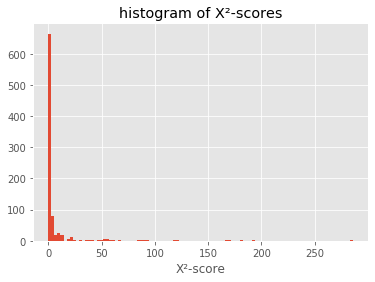

In [25]:
plt.hist(sorted(D["chi_squared_score"]),bins=100)
plt.title("histogram of X²-scores")
plt.xlabel("X²-score")

In [26]:
D

reference_name     start  ...  alt_freq alt_freq_from_1KG
0               17  41196362  ...    0.0050            0.0100
1               17  41196367  ...    0.0005            0.0005
2               17  41196371  ...    0.0005            0.0005
3               17  41196402  ...    0.0005            0.0005
4               17  41196407  ...    0.3118            0.3100
..             ...       ...  ...       ...               ...
874             17  41277353  ...    0.0005            0.0005
875             17  41277363  ...    0.0005            0.0005
876             17  41277390  ...    0.0005            0.0005
877             17  41277392  ...    0.0023            0.0023
878             17  41277459  ...    0.0050            0.0100

[879 rows x 16 columns]

In [35]:
len(D.index)

879

*Calculate p-values from X²-statistics with Bonferroni-correction*

In [90]:
# benjamini-hochberg corrected p-values:
p = 0.05 # 5% significance
m = len(D.index)
Q = [st.chi2.ppf(((i+1)/m)*p, 879) < x for i,x in enumerate(sorted(D["chi_squared_score"].dropna(), reverse=True))]
print("%d significant changes of single bases over time."%sum(Q))

0 significant changes of single bases over time.
